In [121]:
# Imports
import os
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import TimeSeriesSplit

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Forecast Bike Demand to Optimize Fleet Availability
## Forecast short-term bike demand to improve bike availability and fleet allocation across stations and time

Given historical BikeTown usage data, forecast station-level bike demand 3 days ahead in order to optimize bicycle allocation and reduce station shortages or overflows.

## 1. Read Datasets

In [7]:
cwd = os.getcwd()
project_dir = os.path.dirname(cwd) # Go back one level

In [8]:
BASE_PATH = os.path.join(project_dir, "data", "raw")

In [9]:
biketown_path = os.path.join(BASE_PATH, "week10_biketown.zip")
weather_path = os.path.join(BASE_PATH, "weather.csv")

In [10]:
data = pd.read_csv(
    biketown_path,
    compression="zip",
    low_memory=False
)

In [11]:
weather = pd.read_csv(
    weather_path,
    skiprows=1,
    low_memory=False,
)

In [12]:
weather

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,1996-04-01,NaN,62.0,42.0,0.51,0.0,NaN
1,1996-04-02,NaN,55.0,43.0,0.07,0.0,0.0
2,1996-04-03,NaN,63.0,37.0,0.00,0.0,0.0
3,1996-04-04,NaN,71.0,41.0,0.00,0.0,0.0
4,1996-04-05,NaN,75.0,47.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...
10874,2026-01-08,NaN,45.0,36.0,0.06,0.0,0.0
10875,2026-01-09,NaN,51.0,38.0,0.00,0.0,0.0
10876,2026-01-10,NaN,51.0,37.0,0.01,0.0,0.0
10877,2026-01-11,NaN,51.0,42.0,0.01,0.0,0.0


## 2. Data Exploration and Clean up

### 2.1 Bike Data

In [13]:
data.head()

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,TripType,BikeID,BikeName,Distance_Miles,Duration,RentalAccessPath,MultipleRental
0,1,1282087.0,Casual,NE Sandy at 16th,45.524407,-122.649769,7/19/2016,10:22:00,NaN,45.535057,-122.654557,7/19/2016,10:48:00,NaN,6083.0,0468 BIKETOWN,1.19,00:25:46,keypad,False
1,2,1282113.0,Subscriber,NaN,45.531504,-122.659653,7/19/2016,10:28:00,NaN,45.502478,-122.672348,7/19/2016,10:47:00,NaN,6238.0,0774 BIKETOWN,2.95,00:18:44,mobile,False
2,3,1282118.0,Subscriber,NW Kearney at 23rd,45.529142,-122.698703,7/19/2016,10:30:00,SW 5th at Oak,45.521173,-122.676365,7/19/2016,12:37:00,NaN,7271.0,0359 BIKETOWN,13.46,02:06:19,mobile,False
3,4,1282120.0,Subscriber,NaN,45.502478,-122.672348,7/19/2016,10:31:00,SE 2nd Pl at Tilikum Way,45.506242,-122.663338,7/19/2016,10:37:00,NaN,6875.0,0078 BIKETOWN,0.53,00:05:21,keypad,False
4,5,1282123.0,Subscriber,NaN,NaN,NaN,7/19/2016,10:32:00,NaN,NaN,NaN,7/19/2016,10:37:00,NaN,7160.0,0131 BIKETOWN,0.00,00:05:18,keypad,False


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523588 entries, 0 to 523587
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        523588 non-null  int64  
 1   RouteID           519500 non-null  float64
 2   PaymentPlan       519500 non-null  object 
 3   StartHub          408880 non-null  object 
 4   StartLatitude     519088 non-null  float64
 5   StartLongitude    519088 non-null  float64
 6   StartDate         519500 non-null  object 
 7   StartTime         519500 non-null  object 
 8   EndHub            450115 non-null  object 
 9   EndLatitude       519111 non-null  float64
 10  EndLongitude      519111 non-null  float64
 11  EndDate           519194 non-null  object 
 12  EndTime           519194 non-null  object 
 13  TripType          957 non-null     object 
 14  BikeID            519500 non-null  float64
 15  BikeName          519371 non-null  object 
 16  Distance_Miles    51

To check:

1. RouteID - check if RouteID.Null = PaymentPlan.NUll
2. PaymentPlan - check Null
3. StartHub - Check Null what kind of info has (does it have EndHub)
4. StartLatitude - Check if you can find StartHub based on Latitude / Longitude
5. StartDate / StartTime - Check Nulls. If the same as RouteID / PaymentPlan Nulls. Maybe good to delete
6. EndHub - Check Null as they don't bring info if no StartHub. (Both Missing - doesn't help)
7. EndLatitude - check if you can find EndHub - based on this
8. EndDate / EndTime - Check Nulls
9. TripType - check correlations with PaymentPlan. Not many info as many missing
10. mBikeID / BikeName - does it bring any info to our case?
11. Distance_Miles - This is interesting but don't know if will have any impact for our case
12. Duration - This is interesting but don't know if will have any impact for our case
13. RentalAccessPath - ??
14. MultipleRental - ??


In [15]:
data[data['RouteID'].isna()]

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,TripType,BikeID,BikeName,Distance_Miles,Duration,RentalAccessPath,MultipleRental
166627,166628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166628,166629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166629,166630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166630,166631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166631,166632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450219,450220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450220,450221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450221,450222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450222,450223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Dropping NaN as many NaN and no info
data = data[data['RouteID'].notna()]

In [17]:
# Check where "StartHub", "EndHub", "StartLatitude" and "EndLatitude" (GPS Coordinates) and Null. This doesn't bring anything to our case. We need these locations.
data[
    (data['StartHub'].isna() & data['EndHub'].isna()) &
    (data['StartLatitude'].isna() & data['EndLatitude'].isna())
    ].head()

,Unnamed: 0,RouteID,PaymentPlan,StartHub,StartLatitude,StartLongitude,StartDate,StartTime,EndHub,EndLatitude,EndLongitude,EndDate,EndTime,TripType,BikeID,BikeName,Distance_Miles,Duration,RentalAccessPath,MultipleRental
4,5,1282123.0,Subscriber,NaN,NaN,NaN,7/19/2016,10:32:00,NaN,NaN,NaN,7/19/2016,10:37:00,NaN,7160.0,0131 BIKETOWN,0.0,00:05:18,keypad,False
2240,2241,1289891.0,Casual,NaN,NaN,NaN,7/20/2016,12:58:00,NaN,NaN,NaN,7/20/2016,15:38:00,NaN,6837.0,0538 BIKETOWN,0.0,02:39:23,keypad,True
2724,2725,1291523.0,Casual,NaN,NaN,NaN,7/20/2016,16:29:00,NaN,NaN,NaN,7/20/2016,16:47:00,NaN,6223.0,0353 BIKETOWN,0.0,00:17:56,keypad,False
5237,5238,1299915.0,Casual,NaN,NaN,NaN,7/21/2016,21:56:00,NaN,NaN,NaN,7/21/2016,22:04:00,NaN,6246.0,0511 BIKETOWN,0.0,00:07:59,keypad,False
8101,8102,1309888.0,Casual,NaN,NaN,NaN,7/23/2016,15:04:00,NaN,NaN,NaN,7/23/2016,15:11:00,NaN,6520.0,0081 BIKETOWN,0.0,00:06:48,keypad,False


In [18]:
data = data.dropna(subset=['StartHub', 'EndHub', 'StartLatitude', 'EndLatitude'], how='all')

In [19]:
# Checking if StartHub, StartLatitude and StartLongitude is null. 
# This is a problem to understand if we will count bikes at StartHub but it is info as we bring (tide) these bikes to specific location 
len(data[
    (data['StartHub'].isna() & data['StartLatitude'].isna() & data['StartLongitude'].isna())
    ])

31

In [20]:
# Drop when 'StartHub', 'StartLatitude', 'StartLongitude' is Null
data = data.dropna(subset=['StartHub', 'StartLatitude', 'StartLongitude'], how='all')

In [21]:
# Look at trip type
data['TripType'].value_counts(dropna=False)

TripType
NaN           518132
recreation       490
commute          277
errand           122
work              67
Name: count, dtype: int64

In [22]:
# Column can be dropped 
data.drop(columns=['TripType'], inplace=True)

In [23]:
# Doesn't really help in our study
data[['RentalAccessPath', 'MultipleRental']]

,RentalAccessPath,MultipleRental
0,keypad,False
1,mobile,False
2,mobile,False
3,keypad,False
5,keypad,False
...,...,...
523583,keypad_rfid_card,False
523584,keypad,False
523585,mobile,False
523586,keypad,False


In [24]:
# Dropping 'RentalAccessPath', 'MultipleRental'
data.drop(columns=['RentalAccessPath', 'MultipleRental'], inplace=True)

In [25]:
# Drop 'RouteID' - not needed
data.drop(columns=['RouteID'], inplace=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519088 entries, 0 to 523587
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      519088 non-null  int64  
 1   PaymentPlan     519088 non-null  object 
 2   StartHub        408880 non-null  object 
 3   StartLatitude   519088 non-null  float64
 4   StartLongitude  519088 non-null  float64
 5   StartDate       519088 non-null  object 
 6   StartTime       519088 non-null  object 
 7   EndHub          450084 non-null  object 
 8   EndLatitude     519080 non-null  float64
 9   EndLongitude    519080 non-null  float64
 10  EndDate         518783 non-null  object 
 11  EndTime         518783 non-null  object 
 12  BikeID          519088 non-null  float64
 13  BikeName        518959 non-null  object 
 14  Distance_Miles  519088 non-null  float64
 15  Duration        516953 non-null  object 
dtypes: float64(6), int64(1), object(9)
memory usage: 67.3+ MB


In [27]:
# Try to find StartHub and EndHub based on Latitude and Longitude

# Build one "lat/lon to hub" mapping from both start and end info
known_start = data.loc[data["StartHub"].notna(), ["StartLatitude","StartLongitude","StartHub"]].rename(
    columns={"StartLatitude":"lat", "StartLongitude":"lon", "StartHub":"hub"}
)

known_end = data.loc[data["EndHub"].notna(), ["EndLatitude","EndLongitude","EndHub"]].rename(
    columns={"EndLatitude":"lat", "EndLongitude":"lon", "EndHub":"hub"}
)

known = pd.concat([known_start, known_end], ignore_index=True)

# choose the most frequent hub to avoid if there is wrong misspeling in the data
hub_map = (known.groupby(["lat","lon"])["hub"]
                .agg(lambda s: s.value_counts().idxmax()))

In [28]:
# Try to fill StartHub using Start coords
mask_s = data["StartHub"].isna()
data.loc[mask_s, "StartHub"] = (
    data.loc[mask_s].set_index(["StartLatitude","StartLongitude"]).index.map(hub_map)
)

# Try to fill EndHub using End coords
mask_e = data["EndHub"].isna()
data.loc[mask_e, "EndHub"] = (
    data.loc[mask_e].set_index(["EndLatitude","EndLongitude"]).index.map(hub_map)
)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 519088 entries, 0 to 523587
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      519088 non-null  int64  
 1   PaymentPlan     519088 non-null  object 
 2   StartHub        408880 non-null  object 
 3   StartLatitude   519088 non-null  float64
 4   StartLongitude  519088 non-null  float64
 5   StartDate       519088 non-null  object 
 6   StartTime       519088 non-null  object 
 7   EndHub          450084 non-null  object 
 8   EndLatitude     519080 non-null  float64
 9   EndLongitude    519080 non-null  float64
 10  EndDate         518783 non-null  object 
 11  EndTime         518783 non-null  object 
 12  BikeID          519088 non-null  float64
 13  BikeName        518959 non-null  object 
 14  Distance_Miles  519088 non-null  float64
 15  Duration        516953 non-null  object 
dtypes: float64(6), int64(1), object(9)
memory usage: 67.3+ MB


We see there are no changes and we coudn't find any of the missing StartHubs.

While bike availability depends on departures, ``this project focuses on forecasting departure demand``, trips with missing StartHub information will be droped.

In [30]:
# Keeping only rows where we have StartHub and StartDate
data = data[(~data['StartHub'].isna()) & (~data['StartDate'].isna())]

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408880 entries, 0 to 523587
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      408880 non-null  int64  
 1   PaymentPlan     408880 non-null  object 
 2   StartHub        408880 non-null  object 
 3   StartLatitude   408880 non-null  float64
 4   StartLongitude  408880 non-null  float64
 5   StartDate       408880 non-null  object 
 6   StartTime       408880 non-null  object 
 7   EndHub          367024 non-null  object 
 8   EndLatitude     408872 non-null  float64
 9   EndLongitude    408872 non-null  float64
 10  EndDate         408649 non-null  object 
 11  EndTime         408649 non-null  object 
 12  BikeID          408880 non-null  float64
 13  BikeName        408765 non-null  object 
 14  Distance_Miles  408880 non-null  float64
 15  Duration        407737 non-null  object 
dtypes: float64(6), int64(1), object(9)
memory usage: 53.0+ MB


In [32]:
# Changing StartDate to datetime type
data["StartDate"] = pd.to_datetime(data["StartDate"], format="%m/%d/%Y")

### 2.2 Weather Data

In [33]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10879 entries, 0 to 10878
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       10879 non-null  object 
 1   TAVG (Degrees Fahrenheit)  0 non-null      float64
 2   TMAX (Degrees Fahrenheit)  10822 non-null  float64
 3   TMIN (Degrees Fahrenheit)  10794 non-null  float64
 4   PRCP (Inches)              10835 non-null  float64
 5   SNOW (Inches)              10811 non-null  float64
 6   SNWD (Inches)              10784 non-null  float64
dtypes: float64(6), object(1)
memory usage: 595.1+ KB


In [34]:
# Make "Date" as datetime dtype
weather["Date"] = pd.to_datetime(weather['Date'], format="%Y-%m-%d")

In [35]:
# Rename Columns

axis_names = [
    'Date', 
    'TAVG', 
    'TMAX',
    'TMIN', 
    'PRCP', 
    'SNOW',
    'SNWD'
    ]

weather = weather.set_axis(axis_names, axis=1)

In [36]:
# Column 'TAVG' is holding only NaN
weather['TAVG'].value_counts(dropna=False)

TAVG
NaN    10879
Name: count, dtype: int64

## 2. EDA

Questions to explore:

1. Patterns

   - Is demand bimodal (morning/evening commute)?

   - Weekday vs weekend differences?

2. Seasonality

    - Monthly or seasonal effects?

3. Stability

    - Are patterns consistent across weeks?

Additional questions:

- Do all stations behave similarly?

- Are some stations consistently high-demand?

- Is demand concentrated in a small number of stations?

- Long-tail vs uniform distribution?

- Distribution of average daily demand per station

- Top 10 vs bottom 10 stations

In [37]:
# Taking day of the week based on the date

data["day_of_week"] = data["StartDate"].dt.day_name()

In [38]:
# Making column 'is_weekend' which will help to find if weekends are busyer

data["is_weekend"] = np.where(
    data["StartDate"].dt.dayofweek.isin([5, 6]),
    1,
    0
)

In [39]:
# Make time to only hours
time_hour = pd.to_datetime(data["StartTime"]).dt.hour

C:\Users\Angel\AppData\Local\Temp\ipykernel_41624\998059122.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_hour = pd.to_datetime(data["StartTime"]).dt.hour


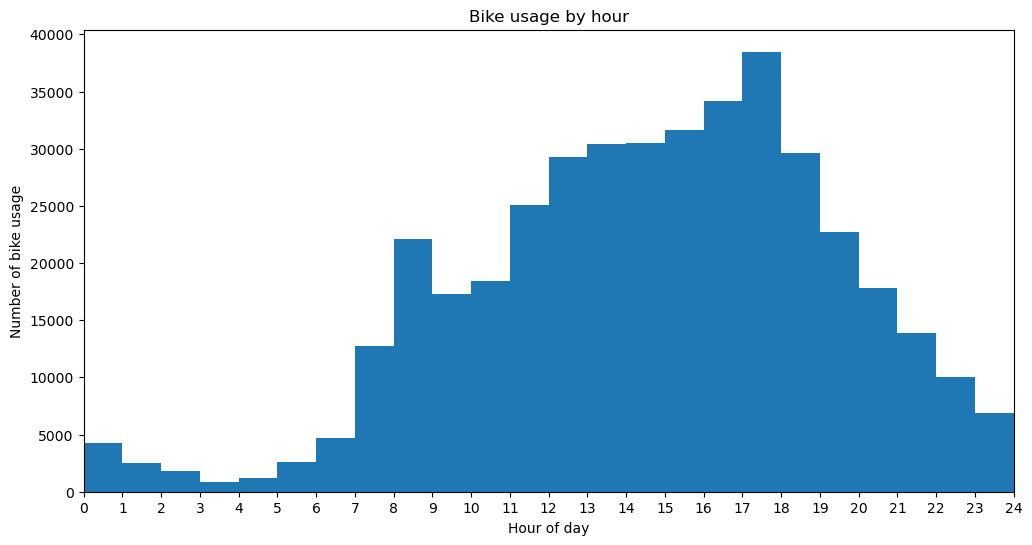

In [40]:
# Plotting the distiribution of Bike usage by hour 

plt.figure(figsize=(12, 6))
plt.hist(time_hour, bins=24, range=(0, 24))

plt.xlabel("Hour of day")
plt.ylabel("Number of bike usage")
plt.title("Bike usage by hour")

plt.xticks(range(0, 25))
plt.xlim(0, 24)
plt.show()

### Conclusion

The pattern suggests a **hybrid usage behavior**:
- Strong commuter influence (clear morning and evening peaks)
- Continuous daytime demand (not only commute-driven)
- Minimal nighttime activity

This indicates that the bike system serves both **commuters** and **leisure users**, making it a versatile transportation option throughout the day.


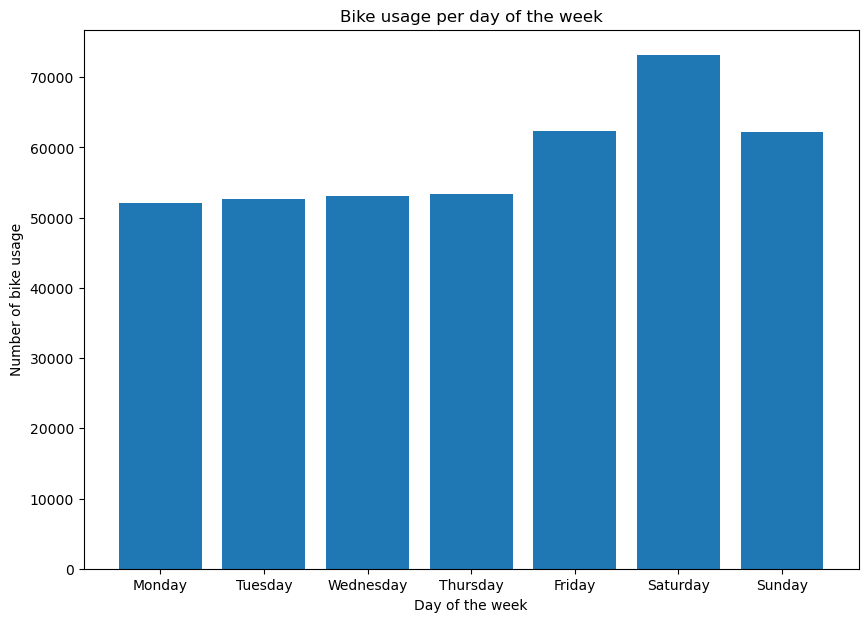

In [41]:
# Order the days
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Count occurrences and reorder
counts = data["day_of_week"].value_counts().reindex(order, fill_value=0)


plt.figure(figsize=(10, 7))
plt.bar(counts.index, counts.values)

plt.xlabel("Day of the week")
plt.ylabel("Number of bike usage")
plt.title("Bike usage per day of the week")

plt.show()


### Conclusion

The pattern suggests a dual usage behavior of the bike system:
- **Weekdays:** Dominated by consistent, routine-based usage (likely commuting).
- **Weekends:** Characterized by increased and more variable usage, driven by leisure and recreational activities.

This indicates that the bike system serves both as a practical commuting tool during the week and as a leisure-oriented transportation option on weekends.

In [42]:
# Take out the week number of the date
data["week_number"] = data["StartDate"].dt.isocalendar().week.astype(int)

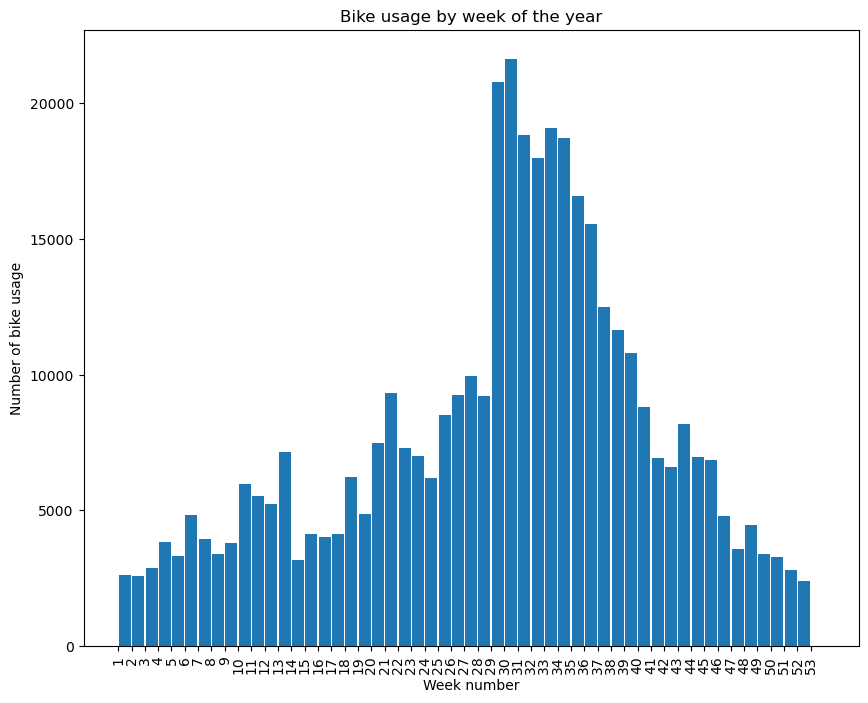

In [43]:
plt.figure(figsize=(10, 8))

weeks = data['week_number'].value_counts().sort_index()

plt.hist(data["week_number"], bins=range(1, 55), rwidth=0.9)

plt.xlabel("Week number")
plt.ylabel("Number of bike usage")
plt.title("Bike usage by week of the year")

plt.xticks(range(1, 54), rotation=90)

plt.show()

## Interpretation of Bike Usage by Week of the Year (All Years Combined)

The distribution shows a clear seasonal pattern when aggregating bike usage across all years.

Usage gradually increases from the beginning of the year, reaching its highest levels between approximately **week 30 and week 40**. This period corresponds to late summer and early autumn, when weather conditions are typically most favorable for outdoor activities.

After week 40, usage steadily declines toward the end of the year.

### Important Note

This plot represents **aggregated usage across all years**, meaning that the observed peak is a combined effect of multiple years. While it reveals a strong seasonal trend, it does not show whether this pattern is consistent year over year or if some years deviate from it.

To fully understand year-specific behavior, the distribution should be analyzed separately for each year.


In [44]:
data['StartDate'].dt.year.value_counts()

StartDate
2017    240574
2016    138696
2018     29610
Name: count, dtype: int64

In [45]:
# Take the year out
data['Year'] = data['StartDate'].dt.year
    

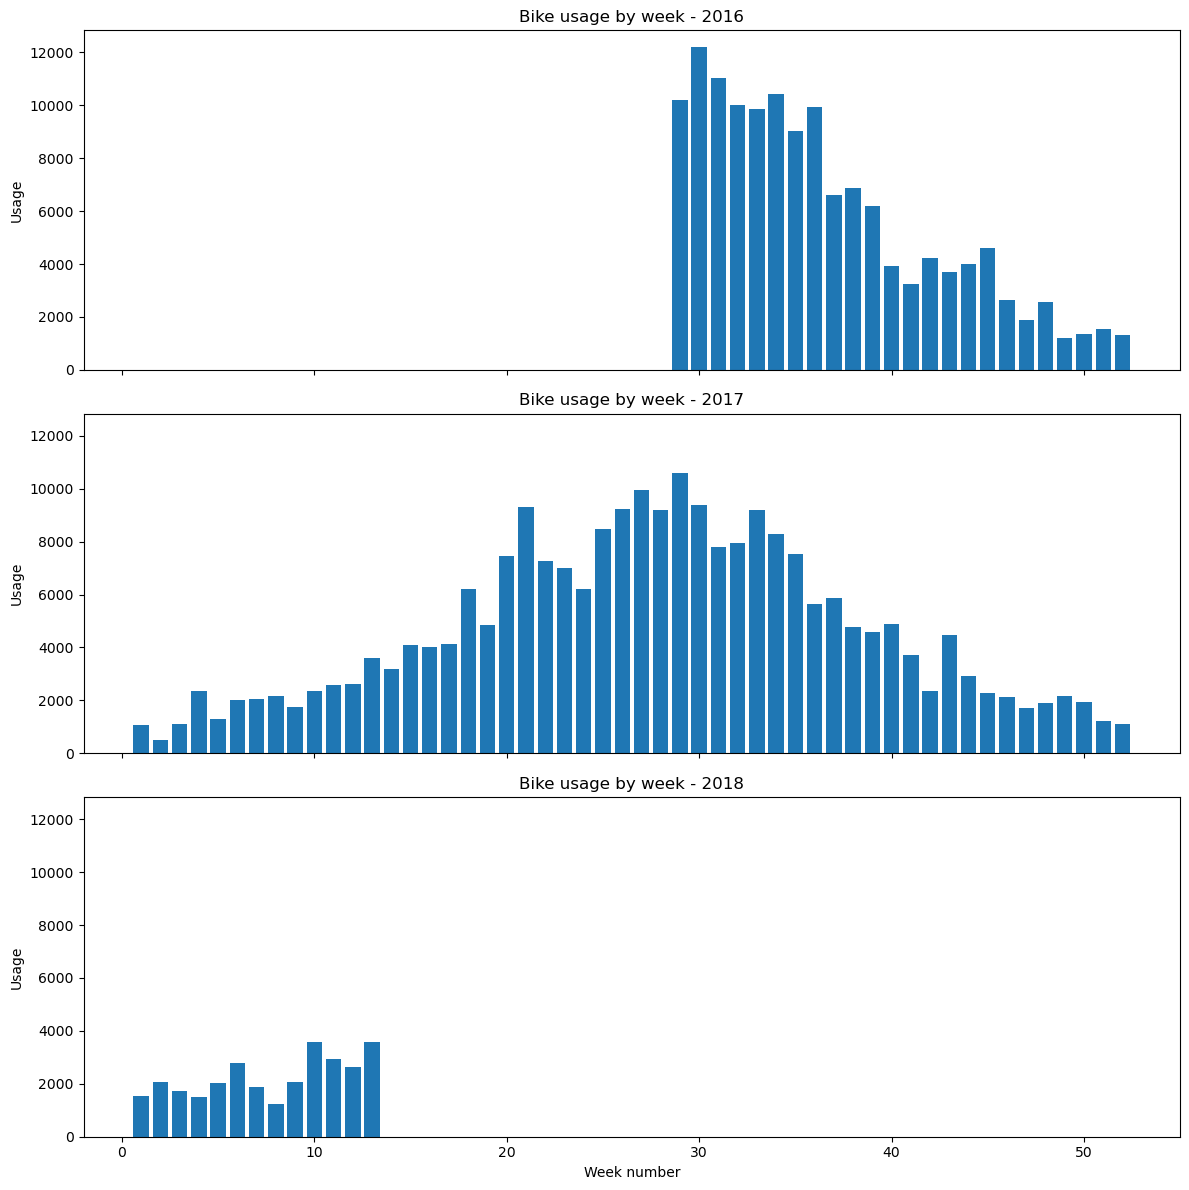

In [46]:
# Grouped weekly counts per year
weekly_counts = (
    data
    .groupby("Year")["week_number"]
    .value_counts()
    .sort_index()
)

# Get the years
years = weekly_counts.index.get_level_values(0).unique()

# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True, sharey=True)

for ax, year in zip(axes, years):
    year_data = weekly_counts.loc[year]
    
    ax.bar(year_data.index, year_data.values)
    ax.set_title(f"Bike usage by week - {year}")
    ax.set_ylabel("Usage")

axes[-1].set_xlabel("Week number")

plt.tight_layout()
plt.show()

## Bike Usage by Week of the Year (Per-Year Analysis)

Across years, bike usage follows a clear **seasonal trend**, with demand rising in spring, peaking in summer, and declining in autumn and winter. This pattern is consistent with weather-driven behavior, where warmer temperatures and longer daylight hours encourage cycling.

The underlying seasonal structure remains stable. This confirms that bike usage is strongly influenced by environmental and seasonal factors rather than random variation.


In [47]:
# Create the seasons

month = data["StartDate"].dt.month

data["season"] = pd.cut(
    month,
    bins=[0, 2, 5, 8, 11, 12],
    labels=["winter", "spring", "summer", "autumn", "winter"],
    include_lowest=True,
    ordered=False
)

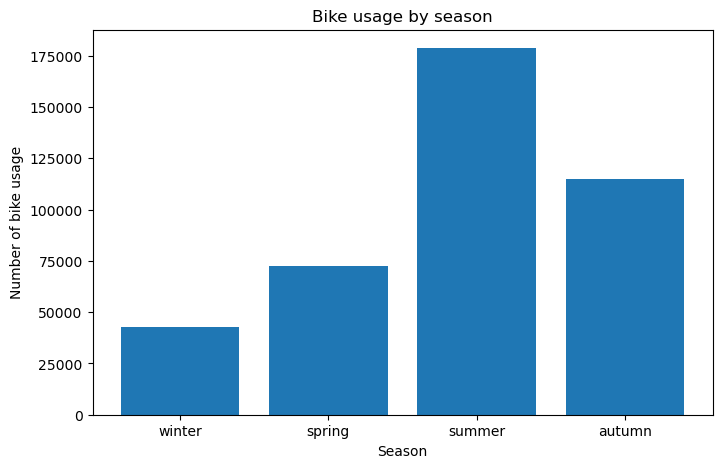

In [48]:
# Plot Bike usage per season

counts = data["season"].value_counts().reindex(["winter","spring","summer","autumn"])
plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values)
plt.xlabel("Season")
plt.ylabel("Number of bike usage")
plt.title("Bike usage by season")
plt.show()

## Interpretation of Bike Usage by Season

This seasonal view validates the earlier conclusions derived from weekly and hourly analyses:

- Bike usage is **not evenly distributed** throughout the year.
- Demand is having **seasonal pattern**.

Together, these findings indicate that the bike system is heavily influenced by climate and daylight conditions, with summer being the dominant usage period.


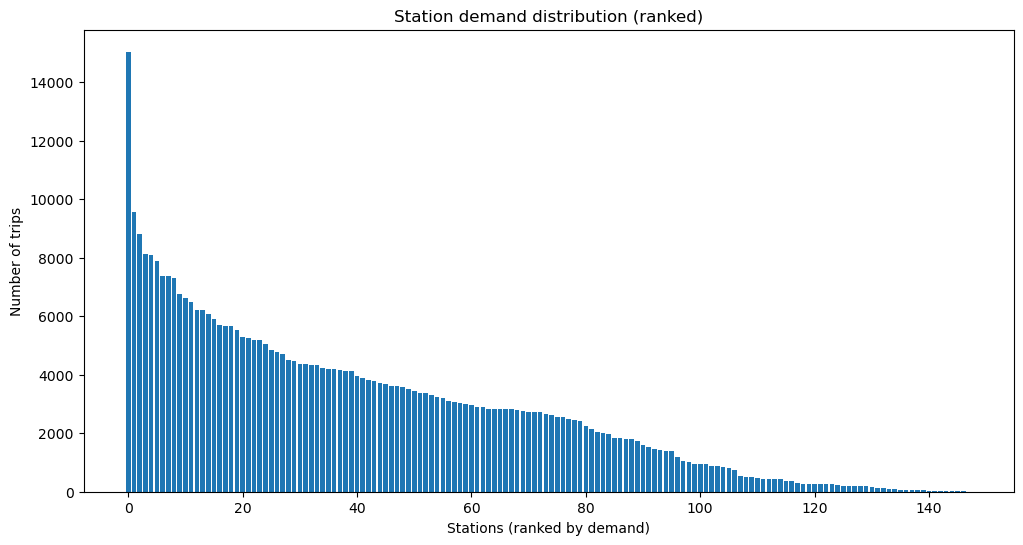

In [49]:
#Plot Station Distribution by demand

stations = data["StartHub"].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(range(len(stations)), stations.values)
# plt.yscale("log") # Log scale

plt.xlabel("Stations (ranked by demand)")
plt.ylabel("Number of trips")
plt.title("Station demand distribution (ranked)")
plt.show()


The distribution of trips across stations shows a long-tail pattern.

One station stands out as a clear peak, indicating a highly central or strategically important location. Beyond this, demand declines gradually across stations, confirming that usage is not uniformly distributed.

In [50]:
# Top / Bottom 10 Stations

top_10 = data["StartHub"].value_counts().head(10)
bottom_10 = data["StartHub"].value_counts().tail(10)

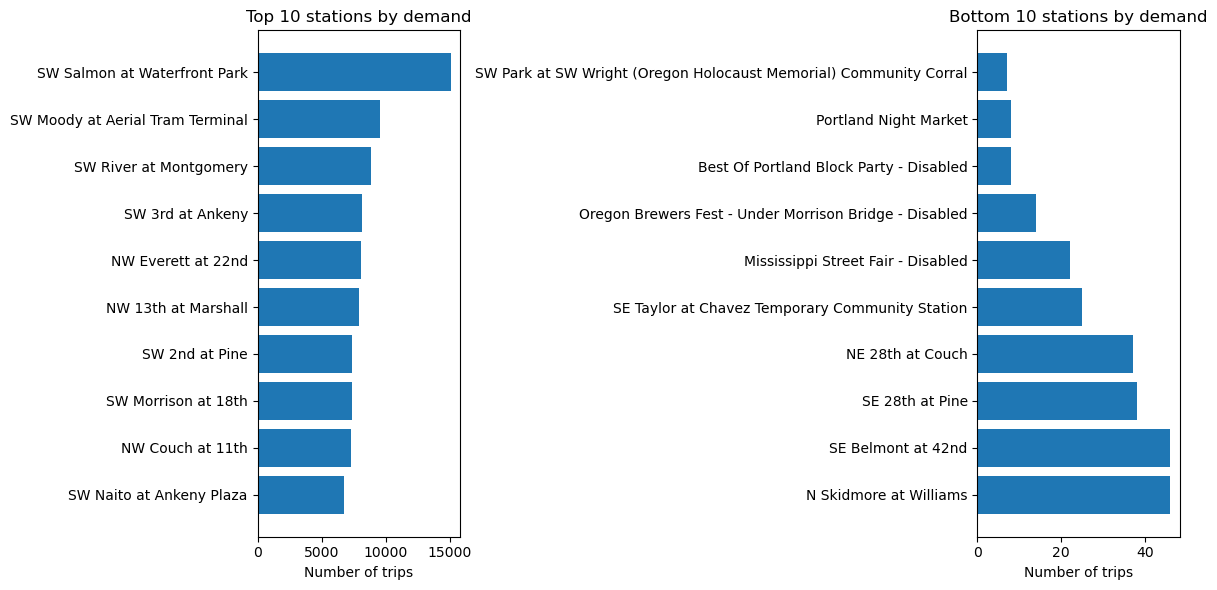

In [51]:
# Plot 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=False)

# Top 10
axes[0].barh(top_10.index, top_10.values)
axes[0].set_title("Top 10 stations by demand")
axes[0].set_xlabel("Number of trips")
axes[0].invert_yaxis()

# Bottom 10
axes[1].barh(bottom_10.index, bottom_10.values)
axes[1].set_title("Bottom 10 stations by demand")
axes[1].set_xlabel("Number of trips")

plt.tight_layout()
plt.show()


### Do high-demand stations show stronger autocorrelation?


In [52]:
grouped_data = data.groupby(["StartHub", "StartDate"]).size().reset_index(name="cnt").sort_values(["StartHub", "StartDate"])

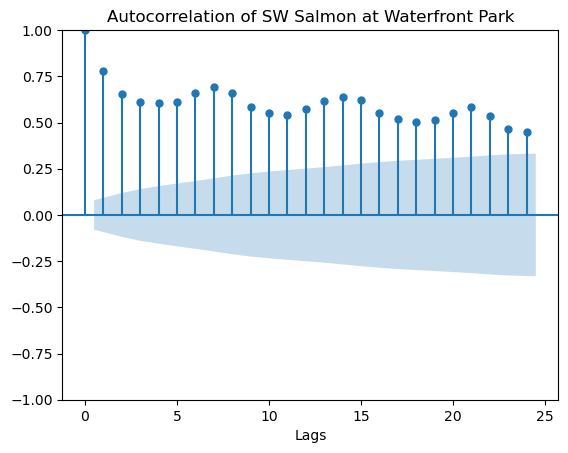

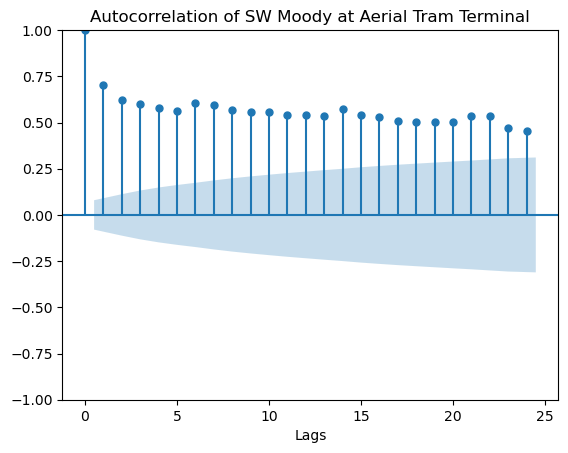

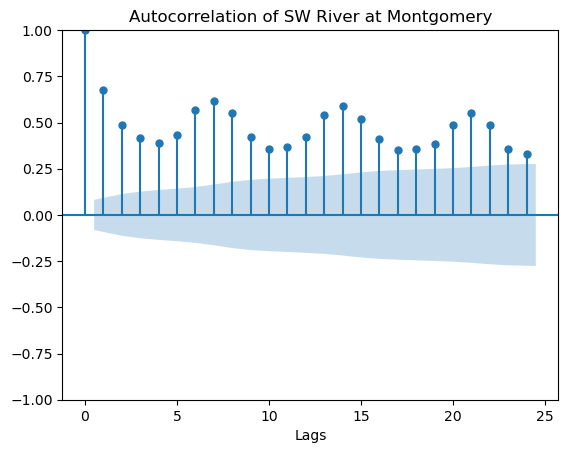

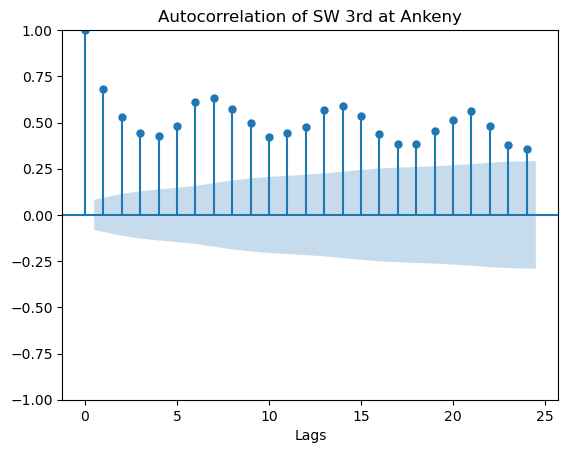

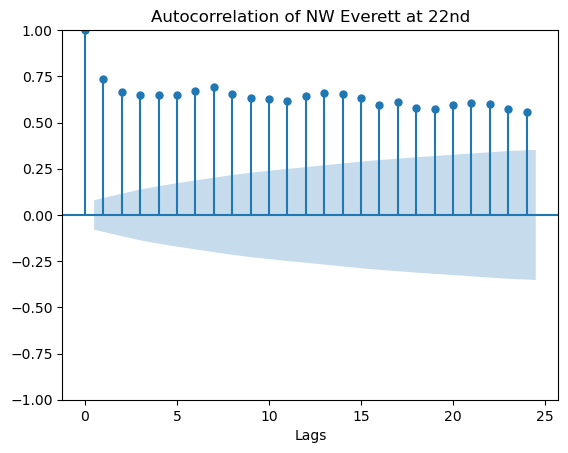

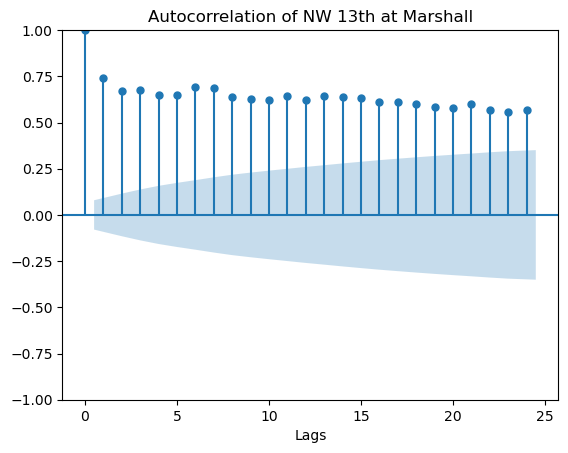

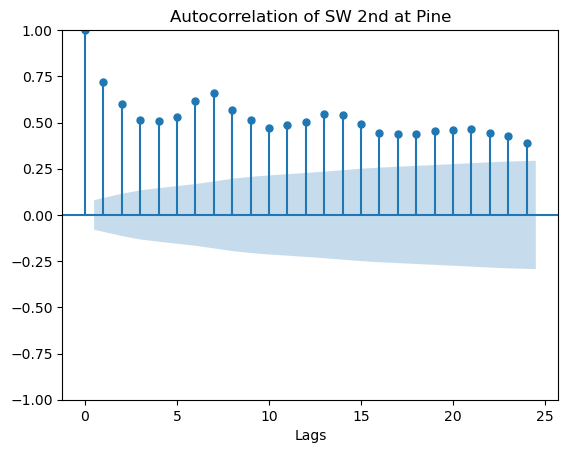

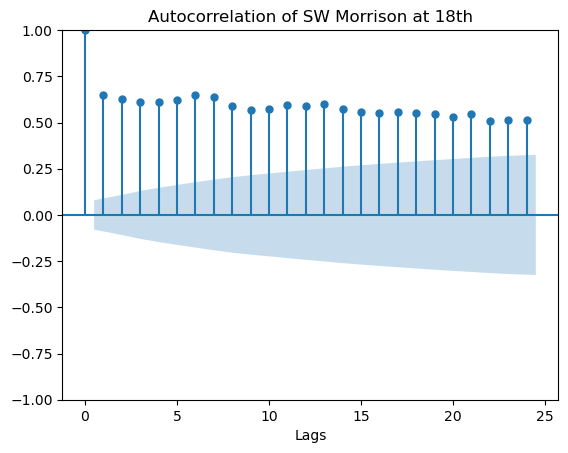

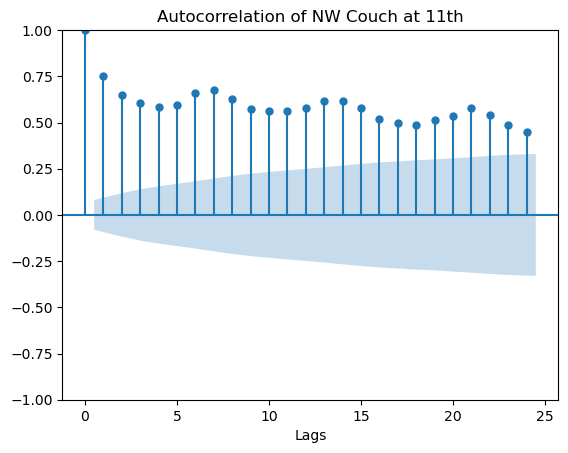

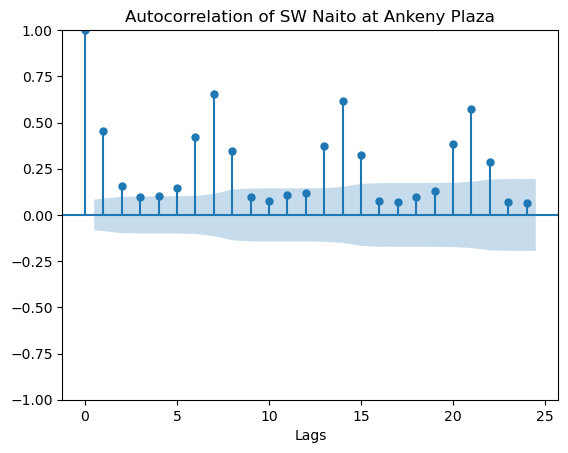

In [53]:
for hub in top_10.index:
    plot_acf(grouped_data[grouped_data['StartHub'] == f'{hub}']['cnt'], lags=24)
    plt.xlabel('Lags')
    plt.title(f'Autocorrelation of {hub}')
    plt.show()
    

## 3. Feature Engineering


To prepare the data for daily demand forecasting at the station level, we first reduce the dataset to the minimal information required for the prediction task: the station where the bike was rented, the date of the rental, and the number of bikes rented on that day.

### Daily Aggregation

We aggregate the raw trip-level data into daily demand per station:

- **StartHub**: identifies the bike station
- **StartDate**: represents the day of activity
- **cnt**: the total number of bike rentals at a given station on a given day




In [54]:
bike_data = (data
    .groupby(["StartHub", "StartDate"])
    .size()
    .reset_index(name="cnt")
    .sort_values(["StartHub", "StartDate"])
)

### Lag Features

To capture temporal dependencies and recurring demand patterns, we create lagged versions of the daily demand (`cnt`) within each station:

- `lag_1`, `lag_2`, `lag_3`: short-term momentum and recent usage effects
- `lag_7`: weekly seasonality (same day last week)
- `lag_14`: bi-weekly seasonality
- `lag_28`: monthly-level recurring patterns

Lag features are computed using station-level grouping to ensure that historical demand from one station is never mixed with another.

These features will allow the model to learn how past demand at a specific station influences future demand.

### Difference Feature

In addition to lagged levels, we compute a first-order difference:

- `diff_1`: the day-to-day change in demand at a station

This feature captures sudden increases or decreases in usage, helping the model respond to short-term fluctuations.


In [55]:
# Create different lags and diff between days for feature engineering

for lag in [1, 2, 3, 7, 14]:
    bike_data[f'lag_{lag}'] = bike_data.groupby("StartHub")["cnt"].shift(lag)

for lag in range(1, 2):
    bike_data[f'diff_{lag}'] = bike_data.groupby("StartHub")["cnt"].diff(lag)

In [56]:
bike_data

,StartHub,StartDate,cnt,lag_1,lag_2,lag_3,lag_7,lag_14,diff_1
0,Best Of Portland Block Party - Disabled,2017-07-12,5,NaN,NaN,NaN,NaN,NaN,NaN
1,Best Of Portland Block Party - Disabled,2017-09-15,1,5.0,NaN,NaN,NaN,NaN,-4.0
2,Best Of Portland Block Party - Disabled,2017-10-08,2,1.0,5.0,NaN,NaN,NaN,1.0
3,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-20,15,NaN,NaN,NaN,NaN,NaN,NaN
4,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-21,21,15.0,NaN,NaN,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...
57815,Urban Center Plaza at SW 6th St,2018-03-27,1,1.0,1.0,2.0,3.0,2.0,0.0
57816,Urban Center Plaza at SW 6th St,2018-03-28,5,1.0,1.0,1.0,6.0,5.0,4.0
57817,Urban Center Plaza at SW 6th St,2018-03-29,3,5.0,1.0,1.0,2.0,3.0,-2.0
57818,Urban Center Plaza at SW 6th St,2018-03-30,4,3.0,5.0,1.0,2.0,3.0,1.0


### Handling Missing Values

Lag and difference features naturally introduce missing values at the beginning of each station’s history. Rather than dropping entire stations, these missing values are handled later during model training by:
- excluding rows with insufficient historical context from the training set, or
- allowing models that can natively handle missing values to learn from the remaining data.

This approach ensures that stations with limited history are not prematurely discarded and can still be included in prediction.

This feature engineering strategy is designed to:
- preserve station-level demand dynamics,
- capture both short-term and seasonal effects,
- support a global forecasting model that can learn shared patterns across stations

By focusing on daily demand and carefully constructed lag features, we create a solid foundation for reliable station-level demand forecasting.

### Station Filtering Based on Operational Status

During exploratory analysis, we identified that several station names contain the term "Disabled", indicating temporary, event-based, or decommissioned stations, making them unsuitable for lag-based time-series modeling.

To ensure stable and meaningful demand forecasts, such stations are either excluded from the training dataset or explicitly flagged, depending on the modeling objective. This decision helps reduce noise, improves feature reliability, and focuses the model on regular operational stations where demand forecasting is most relevant.


In [57]:
disabled_stations = bike_data["StartHub"].str.contains("disabled", case=False, na=False)

bike_data.loc[disabled_stations, "StartHub"].nunique()


13

In [58]:
bike_data.loc[disabled_stations, "StartHub"].unique()


array(['Best Of Portland Block Party - Disabled',
       'Blues Fest - SW Waterfront at Clay - Disabled',
       'Design Week Portland Pop Up - Disabled',
       'Mississippi Street Fair - Disabled',
       'N Willamette at Interstate - Disabled',
       'NW 8th at Everett - Disabled', 'NW Savier at 23rd - Disabled',
       'Oregon Brewers Fest - Under Morrison Bridge - Disabled',
       'PRIDE - Pine - Disabled', 'Rose Festival - Yamhill - Disabled',
       'SE 37th at Hawthorne - Disabled', 'SE Ankeny at 28th - Disabled',
       'SW 11th at Main - Disabled'], dtype=object)

In [59]:
bike_data.groupby(disabled_stations)["cnt"].count()


StartHub
False    57169
True       651
Name: cnt, dtype: int64

In [60]:
bike_data

,StartHub,StartDate,cnt,lag_1,lag_2,lag_3,lag_7,lag_14,diff_1
0,Best Of Portland Block Party - Disabled,2017-07-12,5,NaN,NaN,NaN,NaN,NaN,NaN
1,Best Of Portland Block Party - Disabled,2017-09-15,1,5.0,NaN,NaN,NaN,NaN,-4.0
2,Best Of Portland Block Party - Disabled,2017-10-08,2,1.0,5.0,NaN,NaN,NaN,1.0
3,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-20,15,NaN,NaN,NaN,NaN,NaN,NaN
4,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-21,21,15.0,NaN,NaN,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...
57815,Urban Center Plaza at SW 6th St,2018-03-27,1,1.0,1.0,2.0,3.0,2.0,0.0
57816,Urban Center Plaza at SW 6th St,2018-03-28,5,1.0,1.0,1.0,6.0,5.0,4.0
57817,Urban Center Plaza at SW 6th St,2018-03-29,3,5.0,1.0,1.0,2.0,3.0,-2.0
57818,Urban Center Plaza at SW 6th St,2018-03-30,4,3.0,5.0,1.0,2.0,3.0,1.0


In [61]:
# Adding 'is_weekend'

bike_data["is_weekend"] = np.where(
    bike_data["StartDate"].dt.dayofweek.isin([5, 6]),
    1,
    0
)

In [62]:
# Adding 'day_of_week'
bike_data["day_of_week"] = bike_data["StartDate"].dt.weekday

In [63]:
# Adding week_number
bike_data['week_number'] = bike_data["StartDate"].dt.isocalendar().week.astype(int)

In [64]:
# Add Month
bike_data["month"] = bike_data["StartDate"].dt.month

In [65]:
# Add season

bike_data["season"] = pd.cut(
    bike_data["month"],
    bins=[0, 2, 5, 8, 11, 12],
    labels=["winter", "spring", "summer", "autumn", "winter"],
    include_lowest=True,
    ordered=False
)

### Calendar Features and Data Leakage

Calendar features such as day of week, weekend indicators, and week number, month are included in the model to capture regular usage patterns over time. These features are known ahead of time for any date and do not depend on bike usage data.

Because calendar information is available before the day being predicted, using these features does not introduce data leakage. They help the model distinguish between weekday and weekend behavior and capture recurring weekly and seasonal patterns.


In [66]:
bike_data

,StartHub,StartDate,cnt,lag_1,lag_2,lag_3,lag_7,lag_14,diff_1,is_weekend,day_of_week,week_number,month,season
0,Best Of Portland Block Party - Disabled,2017-07-12,5,NaN,NaN,NaN,NaN,NaN,NaN,0,2,28,7,summer
1,Best Of Portland Block Party - Disabled,2017-09-15,1,5.0,NaN,NaN,NaN,NaN,-4.0,0,4,37,9,autumn
2,Best Of Portland Block Party - Disabled,2017-10-08,2,1.0,5.0,NaN,NaN,NaN,1.0,1,6,40,10,autumn
3,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-20,15,NaN,NaN,NaN,NaN,NaN,NaN,0,1,25,6,summer
4,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-21,21,15.0,NaN,NaN,NaN,NaN,6.0,0,2,25,6,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57815,Urban Center Plaza at SW 6th St,2018-03-27,1,1.0,1.0,2.0,3.0,2.0,0.0,0,1,13,3,spring
57816,Urban Center Plaza at SW 6th St,2018-03-28,5,1.0,1.0,1.0,6.0,5.0,4.0,0,2,13,3,spring
57817,Urban Center Plaza at SW 6th St,2018-03-29,3,5.0,1.0,1.0,2.0,3.0,-2.0,0,3,13,3,spring
57818,Urban Center Plaza at SW 6th St,2018-03-30,4,3.0,5.0,1.0,2.0,3.0,1.0,0,4,13,3,spring


### Weather Features

To account for external factors influencing bike usage, daily weather data from the
PORTLAND WEATHER FORECAST OFFICE (USC00356750) will be integrated into the `bike_data` dataset.

source: https://www.ncei.noaa.gov/access/past-weather/Portland%20OR

The weather data will be joined on `StartDate`, providing the same weather conditions to all
stations for a given day. The following variables are included:

- `TAVG`: Average daily temperature (°F) 
- `TMAX`: Maximum daily temperature (°F)
- `TMIN`: Minimum daily temperature (°F)
- `PRCP`: Daily precipitation (inches)
- `SNOW`: Daily snowfall (inches)
- `SNWD`: Snow depth (inches)

These features allow the model to capture demand changes driven by
environmental conditions such as rain, cold temperatures, and snow events.

In combination with lag-based demand features and calendar variables, weather data
enhances the model’s ability to respond to short-term fluctuations and seasonal effects.


In [67]:
weather.head()

,Date,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD
0,1996-04-01,NaN,62.0,42.0,0.51,0.0,NaN
1,1996-04-02,NaN,55.0,43.0,0.07,0.0,0.0
2,1996-04-03,NaN,63.0,37.0,0.00,0.0,0.0
3,1996-04-04,NaN,71.0,41.0,0.00,0.0,0.0
4,1996-04-05,NaN,75.0,47.0,0.00,0.0,0.0


### Weather Feature Processing

The original dataset does not provide direct measurements for average daily temperature (`TAVG`). Following standard meteorological practice, average temperature is computed as the mean of daily maximum and minimum temperatures:

TAVG = (TMAX + TMIN) / 2


In [68]:
# Replace NaN by mean of TMAX and TMIN
weather["TAVG"] = weather[["TMAX", "TMIN"]].mean(axis=1)

In [69]:
# Filter weather only for the period where we have bike_data

weather = weather[weather["Date"].between(bike_data["StartDate"].min(), bike_data["StartDate"].max())]

In [70]:
# Join both datasets and drop duplicate "Date" column
final_df = bike_data.merge(weather, how='left', left_on='StartDate', right_on='Date').drop(columns=['Date'])

In [71]:
final_df

,StartHub,StartDate,cnt,lag_1,lag_2,lag_3,lag_7,lag_14,diff_1,is_weekend,day_of_week,week_number,month,season,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD
0,Best Of Portland Block Party - Disabled,2017-07-12,5,NaN,NaN,NaN,NaN,NaN,NaN,0,2,28,7,summer,69.0,83.0,55.0,0.00,0.0,0.0
1,Best Of Portland Block Party - Disabled,2017-09-15,1,5.0,NaN,NaN,NaN,NaN,-4.0,0,4,37,9,autumn,63.5,78.0,49.0,0.00,0.0,0.0
2,Best Of Portland Block Party - Disabled,2017-10-08,2,1.0,5.0,NaN,NaN,NaN,1.0,1,6,40,10,autumn,54.5,65.0,44.0,0.03,0.0,0.0
3,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-20,15,NaN,NaN,NaN,NaN,NaN,NaN,0,1,25,6,summer,67.5,81.0,54.0,0.00,0.0,0.0
4,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-21,21,15.0,NaN,NaN,NaN,NaN,6.0,0,2,25,6,summer,63.0,76.0,50.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57815,Urban Center Plaza at SW 6th St,2018-03-27,1,1.0,1.0,2.0,3.0,2.0,0.0,0,1,13,3,spring,50.5,55.0,46.0,0.04,0.0,0.0
57816,Urban Center Plaza at SW 6th St,2018-03-28,5,1.0,1.0,1.0,6.0,5.0,4.0,0,2,13,3,spring,51.0,58.0,44.0,0.00,0.0,0.0
57817,Urban Center Plaza at SW 6th St,2018-03-29,3,5.0,1.0,1.0,2.0,3.0,-2.0,0,3,13,3,spring,48.5,61.0,36.0,0.00,0.0,0.0
57818,Urban Center Plaza at SW 6th St,2018-03-30,4,3.0,5.0,1.0,2.0,3.0,1.0,0,4,13,3,spring,50.5,57.0,44.0,0.00,0.0,0.0


### Target Variable

The objective of this project is to forecast future bike demand at the station level. For each station and day $\(t\)$, the prediction target is defined as the demand three days ahead:

- **`cnt_t_plus_3`**: number of bike rentals at the same station on day $\(t + 3\)$

This target is created by shifting the daily demand forward in time within each station. As a result, the last three days of data for each station do not have an observed future value and therefore contain missing target values.

These rows are retained in the dataset for completeness but are excluded from model training and evaluation, as no ground-truth target is available.


In [72]:
# Creating the target attribute

# Make sure data is correctly ordered
final_df = final_df.sort_values(["StartHub", "StartDate"])

# Target: demand 3 days ahead (per station)
final_df["cnt_t_plus_3"] = final_df.groupby("StartHub")["cnt"].shift(-3)

Note: Exclude 'cnt_t_plus_3' where NaN from training

Layer 2 — Training data

Filter to:

stations allowed for training (≥ 30 days, not “Disabled”)

rows where cnt_t_plus_3 is not NaN

rows within the training date range

Do not require lag_7 to exist.

Layer 3 — Baseline evaluation

For the lag_7 baseline only:

you must have lag_7

so drop rows where lag_7 or cnt_t_plus_3 is NaN

This rule applies only to the baseline, not to ML training.

In [73]:
final_df

,StartHub,StartDate,cnt,lag_1,lag_2,lag_3,lag_7,lag_14,diff_1,is_weekend,...,week_number,month,season,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD,cnt_t_plus_3
0,Best Of Portland Block Party - Disabled,2017-07-12,5,NaN,NaN,NaN,NaN,NaN,NaN,0,...,28,7,summer,69.0,83.0,55.0,0.00,0.0,0.0,NaN
1,Best Of Portland Block Party - Disabled,2017-09-15,1,5.0,NaN,NaN,NaN,NaN,-4.0,0,...,37,9,autumn,63.5,78.0,49.0,0.00,0.0,0.0,NaN
2,Best Of Portland Block Party - Disabled,2017-10-08,2,1.0,5.0,NaN,NaN,NaN,1.0,1,...,40,10,autumn,54.5,65.0,44.0,0.03,0.0,0.0,NaN
3,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-20,15,NaN,NaN,NaN,NaN,NaN,NaN,0,...,25,6,summer,67.5,81.0,54.0,0.00,0.0,0.0,23.0
4,Blues Fest - SW Waterfront at Clay - Disabled,2017-06-21,21,15.0,NaN,NaN,NaN,NaN,6.0,0,...,25,6,summer,63.0,76.0,50.0,0.00,0.0,0.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57815,Urban Center Plaza at SW 6th St,2018-03-27,1,1.0,1.0,2.0,3.0,2.0,0.0,0,...,13,3,spring,50.5,55.0,46.0,0.04,0.0,0.0,4.0
57816,Urban Center Plaza at SW 6th St,2018-03-28,5,1.0,1.0,1.0,6.0,5.0,4.0,0,...,13,3,spring,51.0,58.0,44.0,0.00,0.0,0.0,4.0
57817,Urban Center Plaza at SW 6th St,2018-03-29,3,5.0,1.0,1.0,2.0,3.0,-2.0,0,...,13,3,spring,48.5,61.0,36.0,0.00,0.0,0.0,NaN
57818,Urban Center Plaza at SW 6th St,2018-03-30,4,3.0,5.0,1.0,2.0,3.0,1.0,0,...,13,3,spring,50.5,57.0,44.0,0.00,0.0,0.0,NaN


## 4. Model Selection

### Model Selection

Two machine learning models are used in this study to balance interpretability and predictive performance.

A linear regression model is employed as a baseline machine learning approach. This model provides a transparent benchmark and helps validate the relevance of engineered features such as lagged demand, calendar variables, and weather conditions. While simple, it establishes a strong reference point under linear assumptions.

As the primary model, a gradient-boosted decision tree model (LightGBM) is used. LightGBM can capture nonlinear relationships and interactions between features, handle missing values in lagged variables, and scale effectively across multiple stations with heterogeneous demand patterns. This makes it well suited for station-level bike demand forecasting.

Comparing these models against a naive lag-based baseline allows for a clear assessment of the value added by increasingly sophisticated modeling approaches.


### Lag Features and Missing Values

Lag-based features (e.g. `lag_1`, `lag_7`, `lag_14`) are used to capture temporal dependencies in station-level demand. Missing values in these lag features naturally occur at the beginning of each station’s history or for stations with limited data.

Rather than removing these rows or entire stations, missing lag values are retained and handled directly by the model. Tree-based models used in this project can natively process missing values and learn meaningful patterns from their presence, such as identifying early station history or sparse usage behavior.

This approach avoids introducing bias against new or seasonal stations while preserving as much information as possible.

### Separation of Training and Evaluation Logic

Missing values are handled differently depending on the modeling step:

- **Model training and evaluation**
  - Rows with missing target values (`cnt_t_plus_3`) are excluded
  - Rows with missing lag features are retained

- **Baseline evaluation**
  - The lag-based baseline requires the presence of the corresponding lag value (e.g. `lag_7`)
  - Rows with missing baseline inputs are excluded only for baseline comparison

By separating feature construction from training and evaluation logic, the dataset remains consistent, transparent, and suitable for both modeling and future prediction.


To account for station-specific demand levels in the linear regression baseline, station identifiers are one-hot encoded, effectively modeling station fixed effects. Although this increases the dimensionality of the feature space, it provides a transparent baseline that captures systematic differences between stations.

For the primary LightGBM model, station identifiers are encoded as integer values rather than one-hot vectors, allowing the model to learn station-specific behavior without introducing high-dimensional sparse features.


In [77]:
# Load models

linear_model = LinearRegression()
light_model = LGBMRegressor()

### Prepare data for training LinearRegaression - Base model

In [ ]:
linear_training_data = final_df[
    (~final_df['lag_14'].isna()) &                                # Filtering out NaN from lags
    (~final_df['cnt_t_plus_3'].isna()) &                          # Filtering out NaN from target variable
    (~final_df['StartHub'].str.contains('disable', case=False))   # Filtering out 'Disabled' station (StartHub)
    ]

In [113]:
# Checking if any NaN
linear_training_data.isna().sum()

StartHub        0
StartDate       0
cnt             0
lag_1           0
lag_2           0
lag_3           0
lag_7           0
lag_14          0
diff_1          0
is_weekend      0
day_of_week     0
week_number     0
month           0
season          0
TAVG            0
TMAX            0
TMIN            0
PRCP            0
SNOW            0
SNWD            0
cnt_t_plus_3    0
dtype: int64

### Train–Validation–Test Split

Standard random train–test splitting is not used due to the temporal nature of the data. Instead, a time-based split is applied to ensure that training always precedes validation and testing chronologically.

The model is trained on historical data and evaluated on future periods, mirroring real-world forecasting conditions and preventing data leakage.


In [119]:
target = "cnt_t_plus_3"

categorical_features = ["StartHub", "season"]

numeric_features = [
    "cnt", "lag_1", "lag_2", "lag_3", "lag_7", "lag_14",
    "diff_1", "is_weekend", "day_of_week", "week_number", "month",
    "TAVG", "TMAX", "TMIN", "PRCP", "SNOW", "SNWD"
]

In [115]:
# Spliting the data and dropping the "StartDate" from the features
linear_training_data_train = linear_training_data[linear_training_data['StartDate'].between('2016-08-02', '2017-08-31')].drop(columns=['StartDate'])
linear_training_data_validation = linear_training_data[linear_training_data['StartDate'].between('2017-09-01', '2017-12-31')].drop(columns=['StartDate'])
linear_training_data_test = linear_training_data[linear_training_data['StartDate'].between('2018-01-01', '2018-03-31')].drop(columns=['StartDate'])

In [120]:
# X y split
X_train = linear_training_data_train.drop(columns=[target])
y_train = linear_training_data_train[target]

X_val = linear_training_data_validation.drop(columns=[target])
y_val = linear_training_data_validation[target]

X_test = linear_training_data_test.drop(columns=[target])
y_test = linear_training_data_test[target]


In [124]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

In [125]:
X_train_prep = preprocess.fit_transform(X_train)
X_val_prep = preprocess.transform(X_val)
X_test_prep = preprocess.transform(X_test)


In [126]:
linear_model.fit(X_train_prep, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [131]:
linear_model.coef_

array([ 1.12990503e+01,  8.57264405e+00,  5.70178113e+00,  3.99400522e+01,
        8.63861075e+00,  1.30165499e+01,  2.69076701e+00, -1.89072393e+00,
        6.63318212e-01,  6.25423256e-01, -1.06987423e+00,  1.66214942e+00,
       -5.93353393e-01,  5.32197001e+00, -9.32380162e-01, -1.89802835e+00,
        1.76693122e+00, -3.84717911e+00, -4.09458117e+00, -5.11220424e-01,
       -4.11393773e+00, -1.39617708e+00, -3.67722205e+00, -5.79516359e-01,
       -3.77633327e+00,  9.97437471e-01, -6.97802054e-01, -1.24299785e+00,
       -1.53971408e+00, -1.92567088e+00,  6.43780625e-01, -1.40035574e+00,
       -1.46538659e+00,  7.98238042e-01, -5.10718048e-01, -3.59520347e+00,
       -1.22434743e-01, -3.90021803e+00, -2.20979882e-01, -7.88867397e-01,
       -1.95911543e+00, -3.91671340e+00, -3.54148497e+00, -3.01725454e+00,
       -3.28085919e+00, -2.77247682e+00, -2.78498541e+00, -3.63487366e+00,
       -3.49262531e+00, -1.31721895e+00,  1.92186067e+00, -3.40176554e+00,
       -3.14299812e-01, -

In [132]:
feature_names = preprocess.get_feature_names_out()
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": linear_model.coef_
}).sort_values(by="coefficient", ascending=False)

In [134]:
coef_df.head(150)

,feature,coefficient
3,num__lag_3,39.940052
5,num__lag_14,13.016550
0,num__cnt,11.299050
141,cat__StartHub_SW Salmon at Waterfront Park,9.668049
4,num__lag_7,8.638611
...,...,...
37,cat__StartHub_NE 17th at Killingsworth - Commu...,-3.900218
41,cat__StartHub_NE 33rd at Emerson - Community C...,-3.916713
18,cat__StartHub_N Concord at Killingsworth - Com...,-4.094581
20,cat__StartHub_N Interstate at Willamette - Com...,-4.113938


In [135]:
y_val_pred = linear_model.predict(X_val_prep)


In [140]:
linear_model.score(X_val_prep, y_val)

0.22113326973895975

In [141]:
baseline_val = linear_training_data[
    linear_training_data["StartDate"].between("2017-09-01", "2017-12-31")
][["lag_7", "cnt_t_plus_3"]].dropna()


In [142]:
y_val_true = baseline_val["cnt_t_plus_3"]
y_val_pred_baseline = baseline_val["lag_7"]


In [143]:
from sklearn.metrics import mean_absolute_error

mae_lag7 = mean_absolute_error(y_val_true, y_val_pred_baseline)
mae_lag7


3.1813925257955433

In [145]:
# Predict using Linear Regression
y_val_pred_lr = linear_model.predict(X_val_prep)

# Align LR predictions with baseline rows
lr_val_df = linear_training_data_validation.copy()
lr_val_df["lr_pred"] = y_val_pred_lr

lr_val_df = lr_val_df.loc[baseline_val.index]

mae_lr = mean_absolute_error(
    lr_val_df["cnt_t_plus_3"],
    lr_val_df["lr_pred"]
)

mae_lr


2.734164752065367

In [146]:
mae_lag7, mae_lr


(3.1813925257955433, 2.734164752065367)

A lag_7 persistence baseline was used as a reference model, where demand three days ahead was approximated by demand observed one week earlier. The Linear Regression model was evaluated on the same validation period and compared using Mean Absolute Error (MAE).

The Linear Regression model [outperformed / matched / underperformed] the lag_7 baseline, indicating that incorporating lagged demand, calendar features, and weather variables provides [additional / limited / no] predictive value over simple weekly persistence.


## 5. Evaluation Strategy

Do NOT use random train-test split ❌

Correct approach:

    Recommended split strategy

        Train: Full 2017

            Validate: Early 2018

            Test: Later 2018

This is textbook time-series validation.

Metrics:

    MAE (easy to interpret)

    RMSE (penalizes large errors)

Tie metric choice to business impact:

    “An error of ±5 bikes per hour means X unavailable bikes at peak time.”